<a name='hello'></a>

Привет. Структура моей работы отличается от шаблона.  
Поэтому открой `Table Of Contents` (Оглавление) 
В локальном юпитере View/Left SideBar/Table Of Contents.  
В Colab - вид/содержание.  
Либо можно использовать ссылки под оглавлениями.  
Работа выполнялась локально.  
[Посмотреть сразу результаты](#startmodel)   
[Задания собраны в одном месте](#tasks)  
[summury](#summury)  
Мой телеграмм [@ermakowladislav](https://t.me/ermakowladislav)

# Домашнее задание. Сегментация изображений

В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.

## import

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from dataclasses import dataclass, field
from pathlib import Path
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
import seaborn as sns
import torch
from torchvision.transforms import v2
from torchmetrics.classification import BinaryJaccardIndex
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset as torchDataset
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from pprint import pprint
import gc

<a name='config'></a>

## config

[Посмотреть сразу результаты](#startmodel) 

In [2]:
@dataclass(frozen=True)
class Config(object):
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = 13
    path_dir: str = './data/'
    images: str = "*IMD???.bmp"
    lesions: str = "*lesion.bmp"
    
    new_size: int = 256
    #mean: list[int] = field(default_factory=lambda: (0.48235, 0.45882, 0.40784))  
    #std: list[int] = field(default_factory=lambda: (0.00392, 0.00392, 0.00392)) 
    mean: list[int] = field(default_factory=lambda: (0.485, 0.456, 0.406))
    std: list[int] = field(default_factory=lambda: (0.229, 0.224, 0.225))
    epochs: int = 20
    batch_size: int = 16
    test_size: float = 0.10
    pin_memory:bool = True
    num_workers:int = 2

    criterion: object = nn.BCEWithLogitsLoss()
    optimizer: object = torch.optim.AdamW
    lr:float = 1e-4
    weight_decay: float = 1e-2 
    scheduler: object = torch.optim.lr_scheduler.StepLR
    step_size: int = 7
    gamma:float = 0.1    #0.1

    iou_score:object = BinaryJaccardIndex(threshold=0.5)
    #superkwargs: field(default_factory=dict) = None
    #def __post_init__(self):
       # [setattr(self, k, v) for k, v in self.superkwargs.items()]

In [3]:
#random.seed(Config.seed)
np.random.seed(Config.seed)
torch.manual_seed(Config.seed)
torch.cuda.manual_seed(Config.seed)
torch.backends.cudnn.deterministic = True

In [4]:
images = list(Path(Config.path_dir).rglob(Config.images))
lesions = list(Path(Config.path_dir).rglob(Config.lesions))

In [5]:
#!gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql
#https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

## view_images

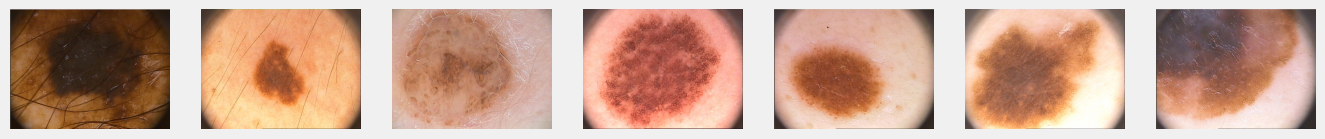

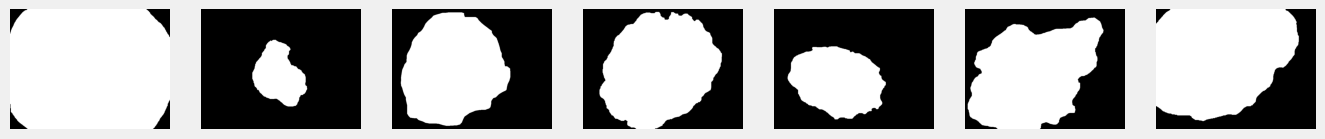

In [6]:
def view_img(*args, ncols=7):
    indx = np.random.choice(np.arange(0, len(args[0])), ncols, replace=False)
    for elems in args:
        fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(15, 2))
        for i, ind in enumerate(indx):
            img = elems[ind]
            if isinstance(img, Path):
                img = Image.open(elems[ind])
            ax[i].imshow(img)
            ax[i].axis("off")
            if isinstance(img, Path): img.close()
        plt.show()

view_img(images, lesions)    

<a name='dst'></a>

# DatasetTransform

[Посмотреть сразу результаты](#startmodel)   

In [7]:
# в Windows+Juputer данный класс нужно поместить в отдельный файл
# datasettransform.py
# from datasettransform import DatasetTransform

#import numpy as np
#from torch.utils.data import Dataset as torchDataset
#from torchvision.transforms import v2
#from PIL import Image
#import torch
class DatasetTransform(torchDataset):

    def __init__(self, X, y=None, 
                 new_size=256, 
                 mean=(0.485, 0.456, 0.406),
                 std=(0.229, 0.224, 0.225),):
        
        self.X = X
        self.y = y
        self.new_size = new_size
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.load_sample(self.X[idx])
        transform = self.transform()
        x = transform(x)
        if self.y is not None:
            y = self.load_sample(self.y[idx])
            y = y.resize((self.new_size, self.new_size))
            y = np.array(y, dtype=int)[np.newaxis, ::]
            return x, y
        return x

    def load_sample(self, pathlib_obj):
        with Image.open(pathlib_obj) as image:
            image.load()
            return image

    def transform(self):
        new_size = self.new_size

        transform = v2.Compose([
            v2.Resize((new_size,new_size)),
            v2.Lambda(lambda x: np.array(x).astype('uint8') / 255),
            v2.ToImage(),
            v2.ToDtype(torch.float32),
            v2.Normalize(self.mean, self.std)
            ])

        return transform

from datasettransform import DatasetTransform

In [8]:
X_train, X_test, y_train, y_test = train_test_split(images, 
                                                    lesions, 
                                                    test_size=Config.test_size,
                                                    random_state=Config.seed
                                                   )
                                                   

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=Config.test_size,
                                                  random_state=Config.seed
                                                 )
for i in (images, X_train, X_val, X_test):
    print(len(i))

200
162
18
20


# Semantic Segmentation NET

<a name='SegNet'></a>

## SegNet
* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

[Task 3 SegNet](#task3segnet)  
[Посмотреть сразу результаты](#startmodel)   

![segnet](https://media.geeksforgeeks.org/wp-content/uploads/20240802165919/SegNet-Architecture.webp)

In [9]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size=2, 
                                 return_indices=True)
        
        self.upsample = nn.MaxUnpool2d(kernel_size=2)

        self.encoder1 = self.step(3, 64)
        self.encoder2 = self.step(64, 128)
        self.encoder3 = self.step(128, 256, three=True)
        self.encoder4 = self.step(256, 512, three=True)
        self.encoder5 = self.step(512, 1024, three=True)

        self.bottleneck = self.step(1024, 1024, kernel_size=1, padding=0)

        self.decoder5 = self.step(1024, 512, three=True)
        self.decoder4 = self.step(512, 256, three=True)
        self.decoder3 = self.step(256, 128, three=True)
        self.decoder2 = self.step(128, 64)
        self.decoder1 = self.step(64, 64, three=-1)
        self.decoder0 = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)

    def step(self, in_channels, out_channels, three=False,
             kernel_size=3, stride=1, padding=1, bias=True):
        
        params = {"kernel_size": kernel_size, 
                  "stride": stride, 
                  "padding": padding, 
                  "bias": bias}
        
        block = [nn.Conv2d(out_channels, out_channels, **params), 
                 nn.ReLU(),
                 nn.BatchNorm2d(out_channels)] * (1+three)
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, **params),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            *block
            )
        return conv

    def forward(self, x):
        x, indices_256to128 = self.pool(self.encoder1(x))
        x, indices_128to64 = self.pool(self.encoder2(x))
        x, indices_64to32 = self.pool(self.encoder3(x))
        x, indices_32to16 = self.pool(self.encoder4(x))
        x, indices_16to8 = self.pool(self.encoder5(x))

        x = self.bottleneck(x)

        x = self.decoder5(self.upsample(x, indices_16to8))
        x = self.decoder4(self.upsample(x, indices_32to16))
        x = self.decoder3(self.upsample(x, indices_64to32))
        x = self.decoder2(self.upsample(x, indices_128to64))
        x = self.decoder1(self.upsample(x, indices_256to128))
        x = self.decoder0(x)

        return x

<a name='uNet'></a>

## U-Net

[Task 9 uNet](#task9unet)  
[Посмотреть сразу результаты](#startmodel)   

![unet](https://aswinvisva.me/images/unet.png)

In [10]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        self.encoder1 = self.step(3, 32)
        self.encoder2 = self.step(32, 64)
        self.encoder3 = self.step(64, 128)
        self.encoder4 = self.step(128, 256)
        self.encoder5 = self.step(256, 512)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1, bias=True,),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1, bias=True,),
            nn.ReLU(),
            nn.BatchNorm2d(512),)

        self.decoder5 = self.step(1024, 256, up=True)
        self.decoder4 = self.step(512, 128, up=True)
        self.decoder3 = self.step(256, 64, up=True)
        self.decoder2 = self.step(128, 32, up=True)
        self.decoder1 = self.step(64, 32, up=True)
        self.decoder0 = nn.Conv2d(32, 1, kernel_size=1, padding=0)

    def step(self, in_channels, out_channels, up=False,
             kernel_size=3, stride=1, padding=1, bias=True, 
             up_kernel_size=2, up_stride=2, up_padding=0):
        
        params = {"kernel_size": kernel_size, 
                  "stride": stride, 
                  "padding": padding, 
                  "bias": bias}
        
        upparams = params.copy()
        upparams.update({"kernel_size": up_kernel_size,
                         "stride": up_stride,
                         "padding": up_padding, })
        
        block = [nn.Conv2d(in_channels, out_channels, **params),
                 nn.ConvTranspose2d(in_channels, out_channels, **upparams)]
        conv = nn.Sequential(
            block[up],
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, **params), 
            nn.ReLU(),
            nn.BatchNorm2d(out_channels)
            )
        return conv

    def forward(self, x):
        x1 = self.pool(self.encoder1(x))
        x2 = self.pool(self.encoder2(x1))
        x3 = self.pool(self.encoder3(x2))
        x4 = self.pool(self.encoder4(x3))
        x5 = self.pool(self.encoder5(x4))

        x = self.bottleneck(x5)

        x = self.decoder5(torch.cat((x, x5), dim=1))
        x = self.decoder4(torch.cat((x, x4), dim=1))
        x = self.decoder3(torch.cat((x, x3), dim=1))
        x = self.decoder2(torch.cat((x, x2), dim=1))
        x = self.decoder1(torch.cat((x, x1), dim=1))
        x = self.decoder0(x)

        return x

<a name='classTrainer'></a>

# Trainer

[Task 4 trainer](#task4trainer)  
[Task 5 inference](#task5inference)  
[Посмотреть сразу результаты](#startmodel)   

In [11]:
class Trainer(object):

    def __init__(self, 
                 model_class: object,
                 criterion:object, 
                 optimizer:object, 
                 scheduler:object,
                 iou_score:object,
                 train_loader:DataLoader,
                 test_loader:DataLoader=None,
                 lr:float=1e-4, 
                 device:str="cpu",
                 weight_decay:float=1e-2,
                 step_size:int=4,
                 gamma:float=0.5,
                ):

        self.model = model_class().to(device)
        self.criterion = criterion
        self.optimizer = optimizer(self.model.parameters(),
                                   lr=lr,
                                   weight_decay=weight_decay)
        self.scheduler = scheduler(self.optimizer, 
                                   step_size=step_size, 
                                   gamma=gamma)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device
        self.iou_score = iou_score.to(device)
        self.history = {}

    def start(self, epochs=5,):

        for epoch in tqdm(range(epochs), desc="Training model"):
            torch.cuda.empty_cache()
            gc.collect()
            scores = self.__train()
            if self.test_loader:
                scores.update(self.__predict_proba(self.test_loader, 
                                                   inference=False))
            for key, value in scores.items():
                self.history.setdefault(key, []).append(value)
            self.model.eval()

            text = "  ".join(f"{k}: {v[-1]:.3f}" for k, v in self.history.items())
            text = f"Epochs {epoch+1:02}/{epochs:02}   " + text
            tqdm.write(text)


        torch.cuda.empty_cache()
        gc.collect()
        return self.history


    def __train(self):
        self.model.train()
        losses = []
        ious = []
        for inputs, labels in self.train_loader:
            self.optimizer.zero_grad()
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
            outputs = self.model(inputs)
            loss = self.criterion(logits=outputs, labels=labels)
            loss.backward()
            self.optimizer.step()
            losses.append(loss.detach().cpu().item())
            iou = self.iou_score(outputs, labels)
            ious.append(iou.detach().cpu().item())

        self.scheduler.step()
        
        return {"train_loss": np.mean(losses), "train_iou": np.mean(ious)}


    def __predict_proba(self, test_loader, inference=True):
        self.model.eval()
        losses = []
        ious = []
        outs = None
        for inputs, labels in test_loader:
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
            with torch.no_grad():
                outputs = self.model(inputs)
            if inference:
                if outs is None:
                    outs = outputs.detach().cpu()
                else:
                    outs = torch.cat((outs, outputs.detach().cpu()))
            else:
                loss = self.criterion(outputs, labels)
                losses.append(loss.detach().cpu().item())
                iou = self.iou_score(outputs, labels)
                ious.append(iou.detach().cpu().item())
        if inference:
            return outs
        return {"test_loss": np.mean(losses), "test_iou": np.mean(ious)}

    def predict(self, test_loader, th=0.5):
        outputs = self.__predict_proba(test_loader, inference=True)
        outputs = torch.sigmoid(outputs).numpy()
        outputs = outputs > th
        return outputs


<a name='supertrainer'></a>

## super_trainer

[Посмотреть сразу результаты](#startmodel) 

In [12]:
def super_trainer(model_class, **to_config):
    history = {}
    cnf = Config(**to_config)
    p_dataset = {"new_size": cnf.new_size, "mean": cnf.mean, "std": cnf.std}
    p_loader = {"batch_size": cnf.batch_size, "pin_memory": cnf.pin_memory, "num_workers": cnf.num_workers}

    train = DataLoader(DatasetTransform(X_train, y_train, **p_dataset), shuffle=True,
                      **p_loader)
    val = DataLoader(DatasetTransform(X_val, y_val, **p_dataset), 
                      **p_loader)
    test = DataLoader(DatasetTransform(X_test, y_test, **p_dataset), 
                      **p_loader)

    for loss in ("bce_loss", "dice_loss", "focal_loss", "dice_bce_loss", "tversky_loss"):
        print("*"*100)
        model = repr(model_class).split(".")[-1].rstrip(">''")
        print(f"Train {model=} with {loss=}")
        trainer = Trainer(model_class,
            criterion=Losses(loss).loss, 
            optimizer=cnf.optimizer, 
            scheduler=cnf.scheduler,
            iou_score=cnf.iou_score,
            train_loader=train,
            test_loader=test,
            lr=cnf.lr, 
            device=cnf.device,
            weight_decay=cnf.weight_decay,
            step_size=cnf.step_size,
            gamma=cnf.gamma,)

        history[loss] = trainer.start(epochs=cnf.epochs)
        out = trainer.predict(val)
        view_img(X_val, y_val, out.squeeze())     

    return history

# Metrics

## IoU (intersection over union) BASE METRIC

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.

Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

## Losses theory

### BCE Loss

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.  
Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{size \times size} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

### The world of segmentation losses

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

<a name='losses_class'></a>

## Losses

[Task 2 bce loss](#task2bce)  
[Task 6 dice loss](#task6dice)  
[Task 7 focal loss](#task7focal)  
[Task 8 Bonus loss](#task8bonus)  
[Посмотреть сразу результаты](#startmodel)   

In [13]:
class Losses:

    def __init__(self, type_loss):
        self.type_loss = type_loss
        self.loss = self.__losses()

    def __losses(self):
        losses = {"bce_loss": self.bce_loss, 
                  "bce_true": self.bce_true, 
                  "dice_score": self.dice_score, 
                  "dice_loss": self.dice_loss, 
                  "focal_loss": self.focal_loss,
                  "tversky_loss": self.tversky_loss,
                  "dice_bce_loss": self.dice_bce_loss
                 }
        return losses[self.type_loss]

    
    @classmethod
    def bce_loss(self, logits, labels, reduction="mean"):
        loss = logits - logits * labels + torch.log(1 + torch.exp(-logits))
        if reduction == "mean":
            loss = loss.mean()
        if reduction == "sum":
            loss = loss.sum()
        return loss
        
    @classmethod
    def bce_true(self, logits, labels, reduction="mean"):
        loss = - (labels * torch.log(torch.sigmoid(logits)) 
                +  (1 - labels) * torch.log(1-torch.sigmoid(logits)) )
        if reduction == "mean":
            loss = loss.mean()
        if reduction == "sum":
            loss = loss.sum()
        return loss

    @classmethod
    def dice_score(self, logits, labels, th=0.5, eps=1e-8, reduction="mean"):
        y = torch.sigmoid(logits) > th
        num = 2 * (labels * y).sum(dim=(2, 3)) + eps
        den = (labels + y).sum(dim=(2, 3)) + eps
        loss = num / den
        if reduction == "mean":
            loss = loss.mean()
        if reduction == "sum":
            loss = loss.sum()
        return loss
    
    @classmethod
    def dice_loss(self, logits, labels, eps=1e-8, reduction="mean"):
        y = torch.sigmoid(logits)
        num = 2 * (labels * y).sum(dim=(2, 3)) + eps
        den = (labels + y).sum(dim=(2, 3)) + eps
        loss = num / den
        if reduction == "mean":
            loss = loss.mean()
        if reduction == "sum":
            loss = loss.sum()
        return 1 - loss

    @classmethod
    def focal_loss(self, logits, labels, eps=1e-8, alpha=0.25, gamma=2, reduction="mean"):
        y = torch.sigmoid(logits)
        y = torch.clamp(y, eps, 1-eps)
        p = y * labels + (1 - y) * (1 - labels)
        loss = (1 - p).pow(gamma) * self.bce_loss(logits, labels, reduction=None)
        
        if alpha >= 0:
            alpha_t = alpha * labels + (1 - alpha) * (1 - labels)
            loss = alpha_t * loss

        if reduction == "mean":
            loss = loss.mean()
        if reduction == "sum":
            loss = loss.sum()
        return loss

    @classmethod
    def tversky_loss(self, logits, labels, eps=1e-8, alpha=0.5, beta=0.5, reduction="mean"):
        y = F.sigmoid(logits) 
        TP = (y * labels).sum(dim=(2, 3))    
        FP = ((1-labels) * y).sum(dim=(2, 3))
        FN = (labels * (1-y)).sum(dim=(2, 3))
        loss = (TP + eps) / (TP + alpha * FP + beta * FN + eps)
        if reduction == "mean":
            loss = loss.mean()
        if reduction == "sum":
            loss = loss.sum()
        return 1 - loss

    
    @classmethod
    def dice_bce_loss(self, logits, labels, eps=1e-8, reduction="mean"):
        dice = self.dice_loss(logits, labels, eps=eps, reduction=None)
        bce = self.bce_loss(logits, labels, reduction=None).sum(dim=(2, 3))
        bce /= logits.shape[-1] * logits.shape[-2] 
        loss = (bce + dice) / 2
        if reduction == "mean":
            loss = loss.mean()
        if reduction == "sum":
            loss = loss.sum()
        return loss

<a name='tasks'></a>

# Tasks

[Посмотреть сразу результаты](#startmodel)   

## 1.  Вывод численно стабильной формулы BCE лосса [1 балл]

Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

[![Снимок.jpg](https://s.iimg.su/s/23/nA58DpVBQ629jBIyJAdmSRQMafnQwEOJcWwEsEGM.jpg)](https://iimg.su/i/FZQvR)

L_BSE= -  log⁡(σ(y ̂ ))  ∙y-  log⁡〖(1- σ(y ̂ ))∙(1-y)〗

L_BSE= -log⁡〖(1/(1+exp⁡(-y ̂ ) ))∙y- log⁡(exp⁡(-y ̂ )/(1+exp⁡(-y ̂ ) )) 〗∙(1-y)

L_BSE=  log⁡〖(1+exp⁡(-y ̂ ) )∙y+(-log⁡(exp⁡(-y ̂ ) )+ log⁡〖(1+exp⁡(-y ̂ ))〗)∙(1-y)〗

L_BSE=  log⁡〖(1+exp⁡(-y ̂ ) )∙y+(y ̂  + log⁡〖(1+exp⁡(-y ̂ ))〗  )∙(1-y)〗

L_BSE=(1-y)∙ y ̂+  log⁡〖(1+exp⁡(-y ̂ ))〗

L_BSE=y ̂-y y ̂+  log⁡〖(1+exp⁡(-y ̂ ))〗


<a name='task2bce'></a>

## 2. Реализуйте в коде оба варианта лосса [1 балл]

Функции bce_loss and bce_true реализованы в [class Losses](#losses_class)

In [14]:
def check_bce_loss():
    bce_torch = nn.BCELoss()
    bce_torch_with_logits = nn.BCEWithLogitsLoss()
    bce_loss = Losses("bce_loss").loss
    bce_true = Losses("bce_true").loss

    data = [
        [torch.randn(3, 2, requires_grad=False), 
         torch.rand(3, 2, requires_grad=False)
        ],
        # с теми же размерностями, что и в датасете
        [torch.randn((2, 1, 3, 3), requires_grad=False), 
         torch.randint(0, 2, (2, 1, 3, 3))
        ]
           ]
    for y_pred, y_true in data:
        print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
        print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
        print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
        print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')
        assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
        assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
        assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
        assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
        print()
    
    print("END")

check_bce_loss()

BCE loss from scratch bce_loss = 0.9058828949928284
BCE loss честно посчитанный = 0.9058828949928284
BCE loss from torch bce_torch = 0.9058828949928284
BCE loss from torch with logits bce_torch = 0.9058828949928284

BCE loss from scratch bce_loss = 0.6029520034790039
BCE loss честно посчитанный = 0.6029520034790039
BCE loss from torch bce_torch = 0.6029520034790039
BCE loss from torch with logits bce_torch = 0.6029520034790039

END


In [15]:
dummpy_sample = {'logits': torch.load('logits.pt', weights_only=False),
                 'labels': torch.load('labels.pt', weights_only=False)}
#dummpy_sample['labels'] = dummpy_sample['labels']
#dummpy_sample['logits'] = dummpy_sample['logits']

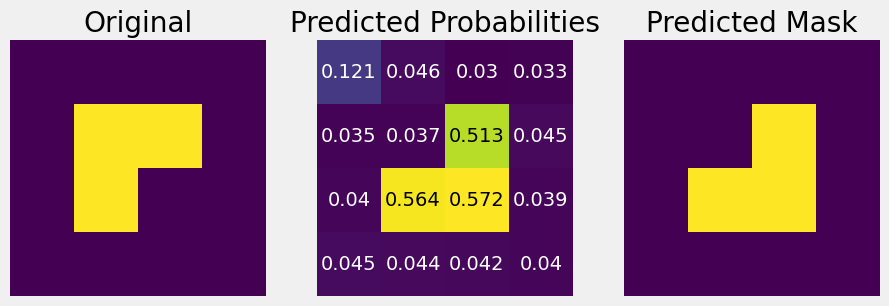

In [16]:
def check_bce_loss_with_real():
    bce_torch = nn.BCELoss() # (sigmoid(y_pred), y_real)
    bce_torch_with_logits = nn.BCEWithLogitsLoss()
    bce_loss = Losses("bce_loss").loss
    bce_true = Losses("bce_true").loss
    #https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
    #!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M
    #https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))
    
    ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
    ax1.set_title("Original")
    
    ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
    for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
        if label < 0.5:
            color = 'white'
        else:
            color = 'black'
        ax2.text(i,j,round(label,3), color=color, ha='center',va='center')
    
    ax2.set_title("Predicted Probabilities")
    
    ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
    ax3.set_title("Predicted Mask")

    ax1.axis("off")
    ax2.axis("off")
    ax3.axis("off")
    
    plt.show()

    bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
    bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
    bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
    bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
    assert np.isclose(bce_loss_score, bce_torch_score)
    assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
    assert np.isclose(bce_true_score, bce_torch_score)
    assert np.isclose(bce_true_score, bce_torch_with_logits_score)

check_bce_loss_with_real()

<a name='task3segnet'></a>

## 3. SegNet [2 балла]
Архитектура SegNet реализована в этой части блокнота [SegNet](#SegNet)

In [17]:
def check_model(model):
    model = model()
    print(model)
    a = torch.rand((2,3,256,256), dtype=torch.float32)
    x = model(a)
    print(x.shape)
    #print(x)

check_model(SegNet)

SegNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128,

<a name='task4trainer'></a>

## 4 Trainer [1 балл]

Тренер реализован в [class Trainer](#classTrainer)  
Тестирование модели реализована в отдельной части ноутбука: [Start trainer model](#startmodel)

<a name='task5inference'></a>

## 5 Инференс [1 балл]

Инференс реализован как функция predict в [class Trainer](#classTrainer)  
Инференс моделей реализован во время тренировки в отдельной части ноутбука: [Start trainer model](#startmodel)

<a name='task6dice'></a>

## 6. Dice Loss [1 балл]
Функции dice_loss and dice_score реализованы в [class Losses](#losses_class)

In [18]:
def check_dice_score():
    dice_score = Losses("dice_score").loss
    from torchmetrics.classification import Dice
    dice = Dice(average='micro')

    a = dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int))
    b = dice_score(dummpy_sample['logits'], dummpy_sample['labels'])
    print(a)
    print(b)
    assert np.isclose(a,b)

check_dice_score()

tensor(0.6667)
tensor(0.6667)


In [19]:
def check_dice_loss():
    dice_loss = Losses("dice_loss").loss
    from segmentation_models_pytorch.losses import DiceLoss
    dice_loss_torch = DiceLoss(mode='binary')
    
    a = dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])
    b = dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])
    print(a)
    print(b)
    assert np.isclose(a,b)
    
check_dice_loss()

tensor(0.5756)
tensor(0.5756)


<a name='task7focal'></a>

## 7. Focal Loss [1 балл]
Функция focal_loss реализована в [class Losses](#losses_class)

In [20]:
def check_focal_loss():
    focal_loss = Losses("focal_loss").loss
    
    from torchvision.ops import sigmoid_focal_loss
    
    a = focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2)
    b = sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction="mean") 
    print(a)
    print(b)
    assert np.isclose(a,b)
    
check_focal_loss()

tensor(0.2260)
tensor(0.2260)


<a name='task8bonus'></a>

## 8. Bonus Loss [5 баллов]
Функции bonus_loss реализованы в [class Losses](#losses_class)

### 8.1 Tversky_loss

In [21]:
def check_tversky_loss():
    tversky_loss = Losses("tversky_loss").loss
    a = tversky_loss(dummpy_sample['logits'], dummpy_sample['labels'])
    print(a)

check_tversky_loss()

tensor(0.5756)


### 8.1 dice_bce_loss

In [22]:
def check_dice_bce_loss():
    dice_bce_loss = Losses("dice_bce_loss").loss
    a = dice_bce_loss(dummpy_sample['logits'], dummpy_sample['labels'])
    print(a)

check_dice_bce_loss()

tensor(0.4745)


<a name='task9unet'></a>

## 9. UNet [2 балла]


Архитектура UNet реализована в этой части блокнота [UNet](#uNet)

In [23]:
check_model(UNet)

UNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Bat

<a name='startmodel'></a>

# Start trainer model

[В начало](#hello)  
[class SegNet](#SegNet)  
[class UNet](#uNet)  
[class Trainer](#classTrainer)  
[class Losses](#losses_class)  
[class DatasetTransform](#dst)  
[class Config](#config)  
[super_trainer](#supertrainer)  
[summury](#summury)  

## Training SegNet

****************************************************************************************************
Train model='SegNet' with loss='bce_loss'


Training model:   0%|          | 0/20 [00:00<?, ?it/s]

Epochs 01/20   train_loss: 0.610  train_iou: 0.424  test_loss: 0.668  test_iou: 0.000
Epochs 02/20   train_loss: 0.381  train_iou: 0.694  test_loss: 0.599  test_iou: 0.000
Epochs 03/20   train_loss: 0.372  train_iou: 0.704  test_loss: 0.360  test_iou: 0.525
Epochs 04/20   train_loss: 0.275  train_iou: 0.737  test_loss: 0.188  test_iou: 0.800
Epochs 05/20   train_loss: 0.264  train_iou: 0.756  test_loss: 0.218  test_iou: 0.752
Epochs 06/20   train_loss: 0.268  train_iou: 0.721  test_loss: 0.137  test_iou: 0.857
Epochs 07/20   train_loss: 0.302  train_iou: 0.698  test_loss: 0.184  test_iou: 0.813
Epochs 08/20   train_loss: 0.225  train_iou: 0.764  test_loss: 0.152  test_iou: 0.826
Epochs 09/20   train_loss: 0.209  train_iou: 0.792  test_loss: 0.154  test_iou: 0.812
Epochs 10/20   train_loss: 0.220  train_iou: 0.784  test_loss: 0.145  test_iou: 0.816
Epochs 11/20   train_loss: 0.186  train_iou: 0.813  test_loss: 0.130  test_iou: 0.836
Epochs 12/20   train_loss: 0.155  train_iou: 0.846  te

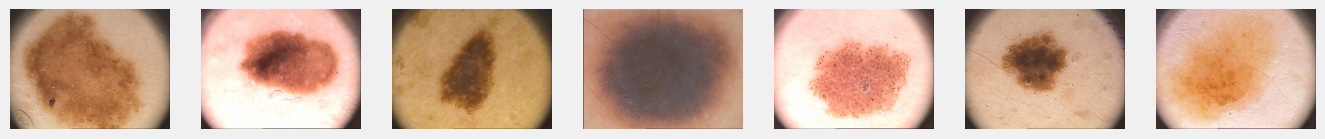

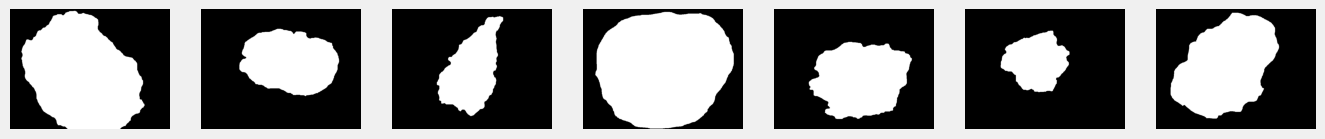

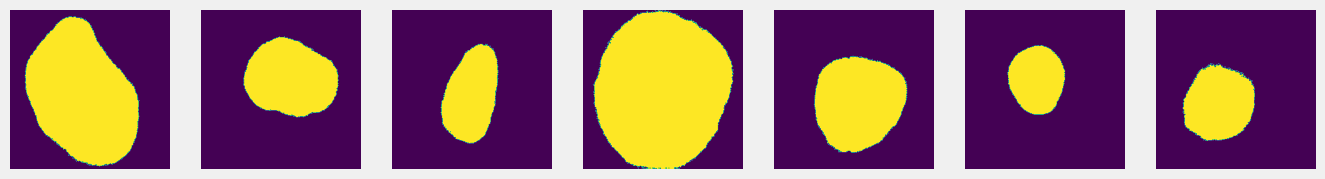

****************************************************************************************************
Train model='SegNet' with loss='dice_loss'


Training model:   0%|          | 0/20 [00:00<?, ?it/s]

Epochs 01/20   train_loss: 0.593  train_iou: 0.379  test_loss: 0.683  test_iou: 0.000
Epochs 02/20   train_loss: 0.387  train_iou: 0.659  test_loss: 0.773  test_iou: 0.000
Epochs 03/20   train_loss: 0.293  train_iou: 0.686  test_loss: 0.258  test_iou: 0.725
Epochs 04/20   train_loss: 0.230  train_iou: 0.725  test_loss: 0.186  test_iou: 0.770
Epochs 05/20   train_loss: 0.197  train_iou: 0.757  test_loss: 0.143  test_iou: 0.824
Epochs 06/20   train_loss: 0.210  train_iou: 0.705  test_loss: 0.134  test_iou: 0.832
Epochs 07/20   train_loss: 0.179  train_iou: 0.748  test_loss: 0.131  test_iou: 0.835
Epochs 08/20   train_loss: 0.133  train_iou: 0.816  test_loss: 0.118  test_iou: 0.859
Epochs 09/20   train_loss: 0.141  train_iou: 0.802  test_loss: 0.120  test_iou: 0.858
Epochs 10/20   train_loss: 0.124  train_iou: 0.830  test_loss: 0.116  test_iou: 0.863
Epochs 11/20   train_loss: 0.151  train_iou: 0.786  test_loss: 0.114  test_iou: 0.872
Epochs 12/20   train_loss: 0.116  train_iou: 0.840  te

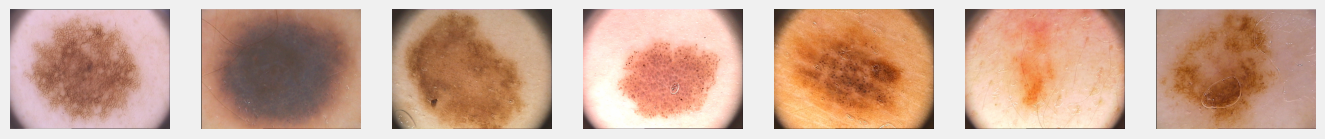

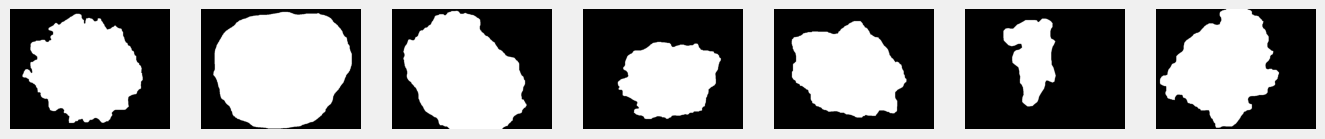

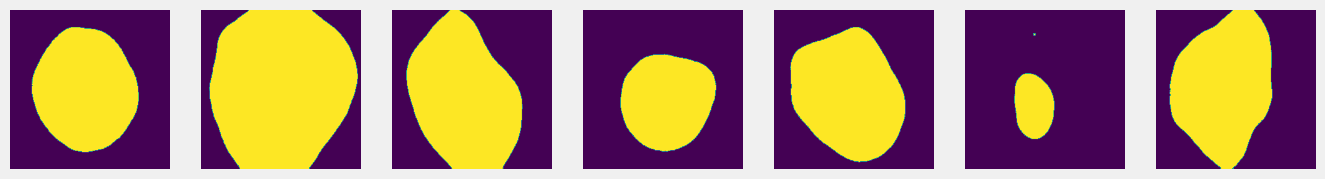

****************************************************************************************************
Train model='SegNet' with loss='focal_loss'


Training model:   0%|          | 0/20 [00:00<?, ?it/s]

Epochs 01/20   train_loss: 0.118  train_iou: 0.309  test_loss: 0.110  test_iou: 0.269
Epochs 02/20   train_loss: 0.085  train_iou: 0.564  test_loss: 0.089  test_iou: 0.003
Epochs 03/20   train_loss: 0.052  train_iou: 0.651  test_loss: 0.051  test_iou: 0.356
Epochs 04/20   train_loss: 0.041  train_iou: 0.703  test_loss: 0.109  test_iou: 0.731
Epochs 05/20   train_loss: 0.036  train_iou: 0.632  test_loss: 0.111  test_iou: 0.774
Epochs 06/20   train_loss: 0.028  train_iou: 0.704  test_loss: 0.061  test_iou: 0.785
Epochs 07/20   train_loss: 0.031  train_iou: 0.717  test_loss: 0.070  test_iou: 0.810
Epochs 08/20   train_loss: 0.027  train_iou: 0.639  test_loss: 0.029  test_iou: 0.802
Epochs 09/20   train_loss: 0.023  train_iou: 0.680  test_loss: 0.023  test_iou: 0.788
Epochs 10/20   train_loss: 0.021  train_iou: 0.707  test_loss: 0.021  test_iou: 0.792
Epochs 11/20   train_loss: 0.024  train_iou: 0.728  test_loss: 0.020  test_iou: 0.787
Epochs 12/20   train_loss: 0.019  train_iou: 0.768  te

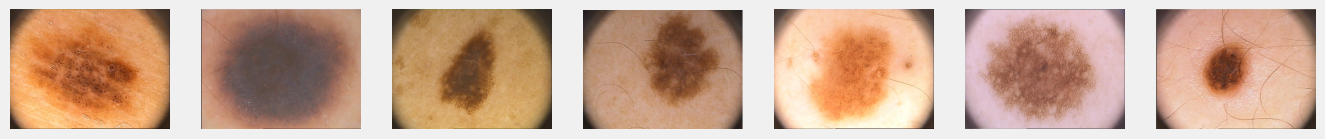

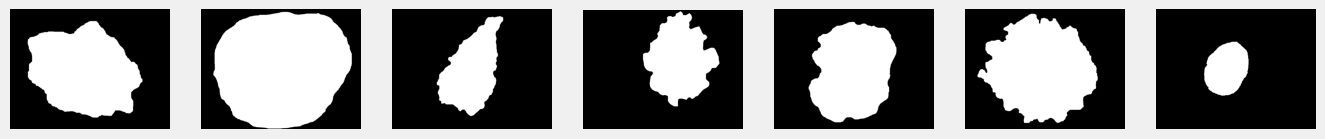

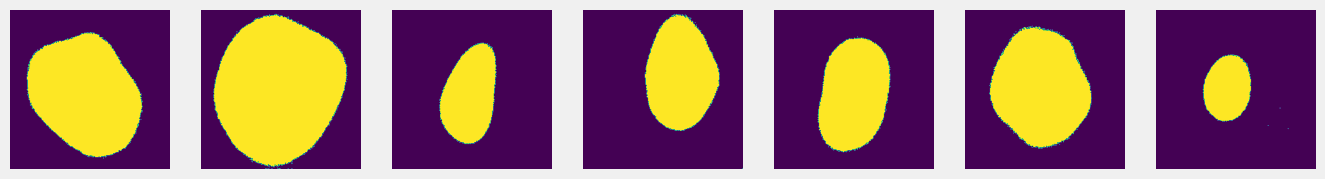

****************************************************************************************************
Train model='SegNet' with loss='dice_bce_loss'


Training model:   0%|          | 0/20 [00:00<?, ?it/s]

Epochs 01/20   train_loss: 0.636  train_iou: 0.338  test_loss: 0.674  test_iou: 0.000
Epochs 02/20   train_loss: 0.428  train_iou: 0.654  test_loss: 0.673  test_iou: 0.000
Epochs 03/20   train_loss: 0.313  train_iou: 0.730  test_loss: 0.341  test_iou: 0.641
Epochs 04/20   train_loss: 0.276  train_iou: 0.747  test_loss: 0.207  test_iou: 0.812
Epochs 05/20   train_loss: 0.274  train_iou: 0.735  test_loss: 0.156  test_iou: 0.844
Epochs 06/20   train_loss: 0.226  train_iou: 0.786  test_loss: 0.173  test_iou: 0.793
Epochs 07/20   train_loss: 0.226  train_iou: 0.769  test_loss: 0.151  test_iou: 0.844
Epochs 08/20   train_loss: 0.203  train_iou: 0.794  test_loss: 0.132  test_iou: 0.858
Epochs 09/20   train_loss: 0.176  train_iou: 0.824  test_loss: 0.125  test_iou: 0.865
Epochs 10/20   train_loss: 0.156  train_iou: 0.846  test_loss: 0.132  test_iou: 0.846
Epochs 11/20   train_loss: 0.171  train_iou: 0.828  test_loss: 0.127  test_iou: 0.855
Epochs 12/20   train_loss: 0.159  train_iou: 0.838  te

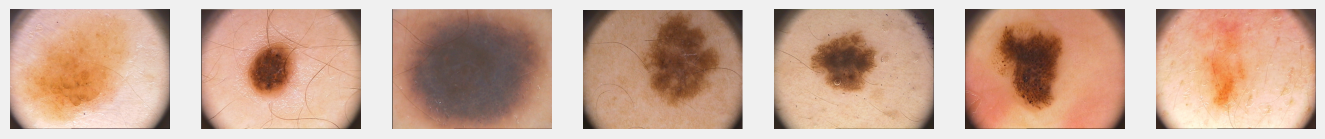

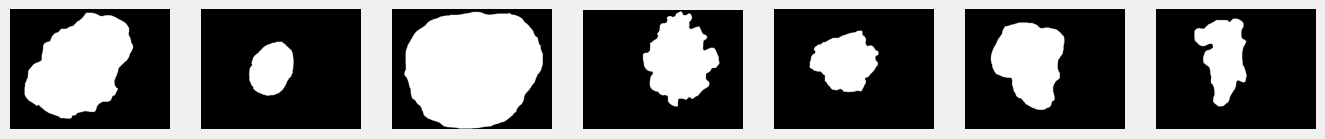

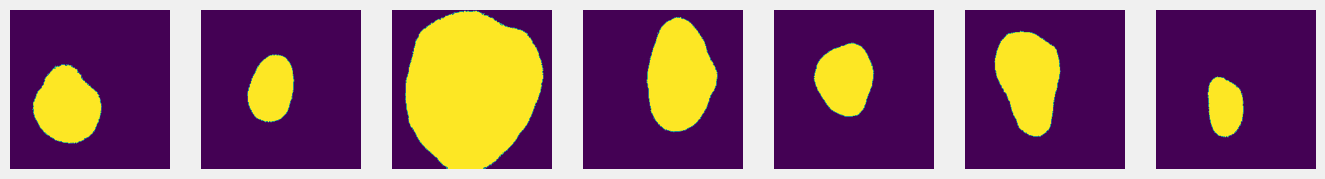

****************************************************************************************************
Train model='SegNet' with loss='tversky_loss'


Training model:   0%|          | 0/20 [00:00<?, ?it/s]

Epochs 01/20   train_loss: 0.575  train_iou: 0.402  test_loss: 0.680  test_iou: 0.000
Epochs 02/20   train_loss: 0.385  train_iou: 0.641  test_loss: 0.764  test_iou: 0.000
Epochs 03/20   train_loss: 0.262  train_iou: 0.716  test_loss: 0.548  test_iou: 0.365
Epochs 04/20   train_loss: 0.251  train_iou: 0.678  test_loss: 0.142  test_iou: 0.836
Epochs 05/20   train_loss: 0.202  train_iou: 0.737  test_loss: 0.169  test_iou: 0.773
Epochs 06/20   train_loss: 0.191  train_iou: 0.741  test_loss: 0.176  test_iou: 0.780
Epochs 07/20   train_loss: 0.173  train_iou: 0.758  test_loss: 0.132  test_iou: 0.844
Epochs 08/20   train_loss: 0.144  train_iou: 0.786  test_loss: 0.129  test_iou: 0.843
Epochs 09/20   train_loss: 0.158  train_iou: 0.790  test_loss: 0.125  test_iou: 0.855
Epochs 10/20   train_loss: 0.113  train_iou: 0.850  test_loss: 0.113  test_iou: 0.871
Epochs 11/20   train_loss: 0.130  train_iou: 0.815  test_loss: 0.110  test_iou: 0.878
Epochs 12/20   train_loss: 0.115  train_iou: 0.837  te

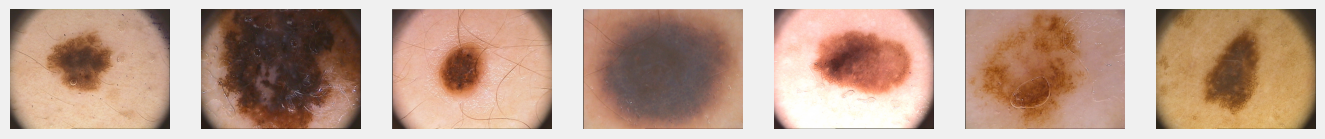

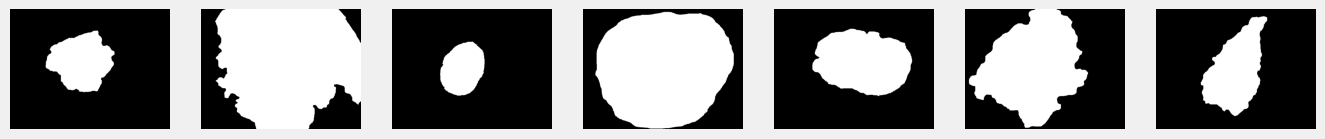

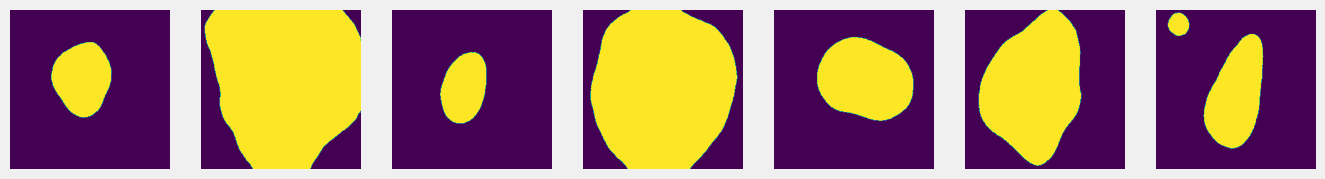

In [24]:
history_segnet = super_trainer(SegNet)

## Training UNet

****************************************************************************************************
Train model='UNet' with loss='bce_loss'


Training model:   0%|          | 0/20 [00:00<?, ?it/s]

Epochs 01/20   train_loss: 0.713  train_iou: 0.340  test_loss: 0.727  test_iou: 0.000
Epochs 02/20   train_loss: 0.584  train_iou: 0.472  test_loss: 0.673  test_iou: 0.391
Epochs 03/20   train_loss: 0.492  train_iou: 0.549  test_loss: 0.517  test_iou: 0.578
Epochs 04/20   train_loss: 0.411  train_iou: 0.630  test_loss: 0.393  test_iou: 0.666
Epochs 05/20   train_loss: 0.365  train_iou: 0.692  test_loss: 0.316  test_iou: 0.745
Epochs 06/20   train_loss: 0.333  train_iou: 0.740  test_loss: 0.251  test_iou: 0.835
Epochs 07/20   train_loss: 0.313  train_iou: 0.775  test_loss: 0.234  test_iou: 0.829
Epochs 08/20   train_loss: 0.289  train_iou: 0.774  test_loss: 0.240  test_iou: 0.835
Epochs 09/20   train_loss: 0.259  train_iou: 0.821  test_loss: 0.234  test_iou: 0.855
Epochs 10/20   train_loss: 0.270  train_iou: 0.796  test_loss: 0.237  test_iou: 0.858
Epochs 11/20   train_loss: 0.271  train_iou: 0.813  test_loss: 0.216  test_iou: 0.882
Epochs 12/20   train_loss: 0.231  train_iou: 0.853  te

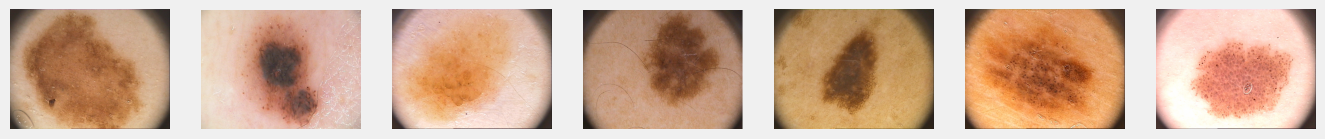

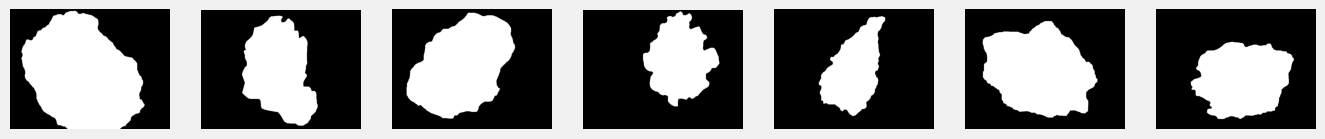

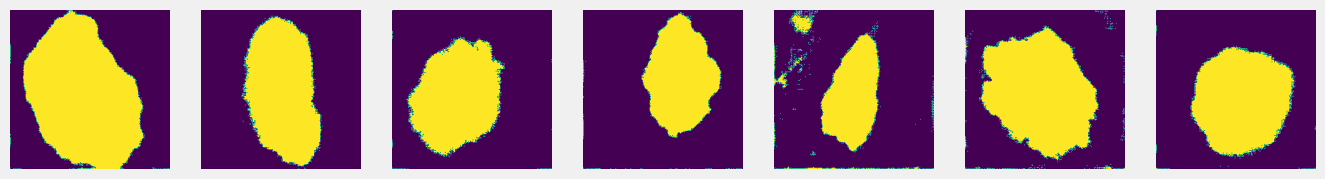

****************************************************************************************************
Train model='UNet' with loss='dice_loss'


Training model:   0%|          | 0/20 [00:00<?, ?it/s]

Epochs 01/20   train_loss: 0.588  train_iou: 0.412  test_loss: 0.664  test_iou: 0.303
Epochs 02/20   train_loss: 0.529  train_iou: 0.509  test_loss: 0.623  test_iou: 0.599
Epochs 03/20   train_loss: 0.442  train_iou: 0.584  test_loss: 0.459  test_iou: 0.609
Epochs 04/20   train_loss: 0.418  train_iou: 0.569  test_loss: 0.392  test_iou: 0.572
Epochs 05/20   train_loss: 0.351  train_iou: 0.657  test_loss: 0.348  test_iou: 0.643
Epochs 06/20   train_loss: 0.326  train_iou: 0.684  test_loss: 0.311  test_iou: 0.667
Epochs 07/20   train_loss: 0.313  train_iou: 0.715  test_loss: 0.291  test_iou: 0.727
Epochs 08/20   train_loss: 0.306  train_iou: 0.729  test_loss: 0.302  test_iou: 0.742
Epochs 09/20   train_loss: 0.305  train_iou: 0.732  test_loss: 0.301  test_iou: 0.757
Epochs 10/20   train_loss: 0.318  train_iou: 0.701  test_loss: 0.305  test_iou: 0.747
Epochs 11/20   train_loss: 0.289  train_iou: 0.739  test_loss: 0.282  test_iou: 0.804
Epochs 12/20   train_loss: 0.322  train_iou: 0.709  te

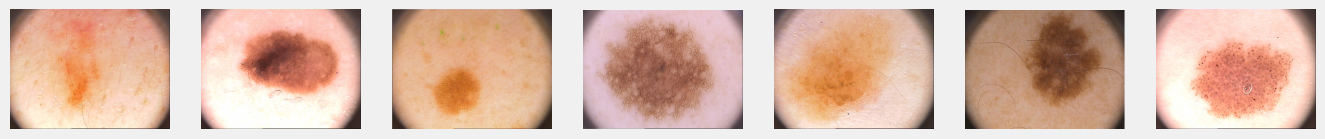

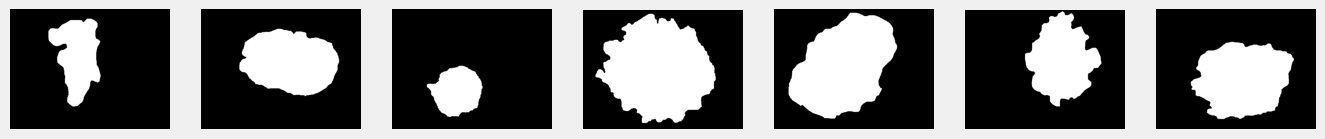

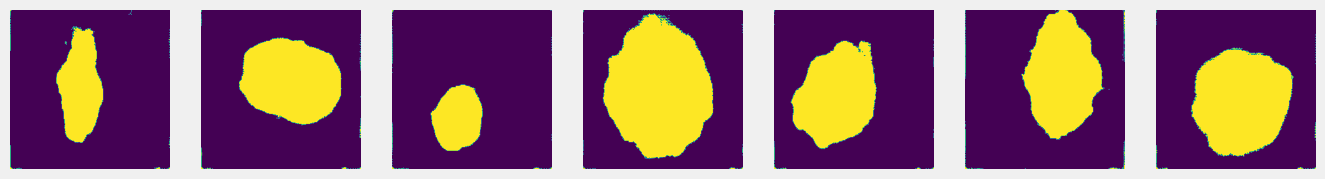

****************************************************************************************************
Train model='UNet' with loss='focal_loss'


Training model:   0%|          | 0/20 [00:00<?, ?it/s]

Epochs 01/20   train_loss: 0.113  train_iou: 0.330  test_loss: 0.099  test_iou: 0.345
Epochs 02/20   train_loss: 0.076  train_iou: 0.537  test_loss: 0.077  test_iou: 0.535
Epochs 03/20   train_loss: 0.067  train_iou: 0.584  test_loss: 0.056  test_iou: 0.679
Epochs 04/20   train_loss: 0.056  train_iou: 0.634  test_loss: 0.049  test_iou: 0.742
Epochs 05/20   train_loss: 0.044  train_iou: 0.719  test_loss: 0.050  test_iou: 0.789
Epochs 06/20   train_loss: 0.047  train_iou: 0.671  test_loss: 0.047  test_iou: 0.773
Epochs 07/20   train_loss: 0.047  train_iou: 0.649  test_loss: 0.043  test_iou: 0.794
Epochs 08/20   train_loss: 0.037  train_iou: 0.728  test_loss: 0.034  test_iou: 0.807
Epochs 09/20   train_loss: 0.035  train_iou: 0.736  test_loss: 0.032  test_iou: 0.816
Epochs 10/20   train_loss: 0.033  train_iou: 0.750  test_loss: 0.031  test_iou: 0.817
Epochs 11/20   train_loss: 0.033  train_iou: 0.757  test_loss: 0.031  test_iou: 0.822
Epochs 12/20   train_loss: 0.034  train_iou: 0.770  te

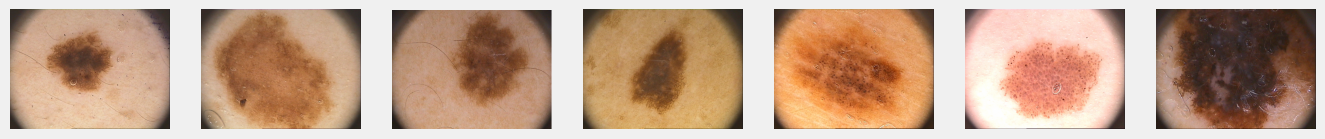

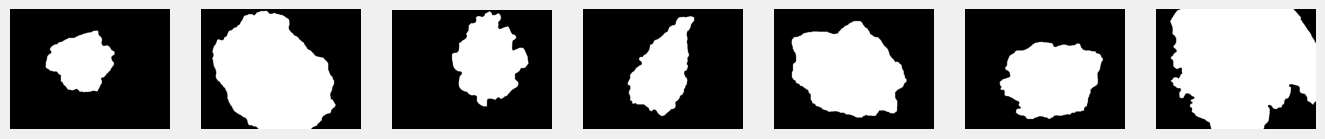

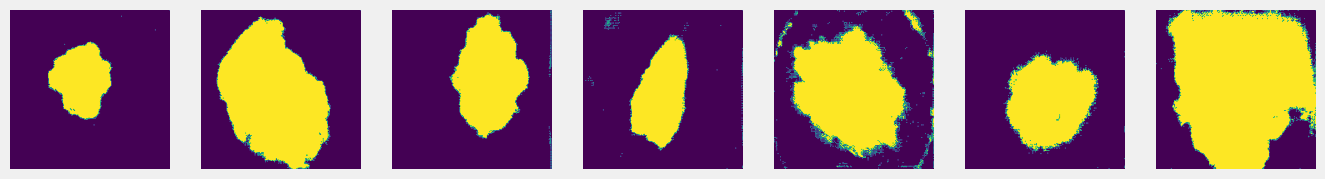

****************************************************************************************************
Train model='UNet' with loss='dice_bce_loss'


Training model:   0%|          | 0/20 [00:00<?, ?it/s]

Epochs 01/20   train_loss: 0.623  train_iou: 0.390  test_loss: 0.675  test_iou: 0.129
Epochs 02/20   train_loss: 0.515  train_iou: 0.552  test_loss: 0.620  test_iou: 0.579
Epochs 03/20   train_loss: 0.457  train_iou: 0.582  test_loss: 0.477  test_iou: 0.633
Epochs 04/20   train_loss: 0.407  train_iou: 0.630  test_loss: 0.381  test_iou: 0.686
Epochs 05/20   train_loss: 0.341  train_iou: 0.732  test_loss: 0.321  test_iou: 0.727
Epochs 06/20   train_loss: 0.323  train_iou: 0.748  test_loss: 0.322  test_iou: 0.720
Epochs 07/20   train_loss: 0.296  train_iou: 0.769  test_loss: 0.277  test_iou: 0.784
Epochs 08/20   train_loss: 0.263  train_iou: 0.823  test_loss: 0.233  test_iou: 0.866
Epochs 09/20   train_loss: 0.263  train_iou: 0.829  test_loss: 0.229  test_iou: 0.876
Epochs 10/20   train_loss: 0.260  train_iou: 0.824  test_loss: 0.229  test_iou: 0.880
Epochs 11/20   train_loss: 0.259  train_iou: 0.829  test_loss: 0.221  test_iou: 0.887
Epochs 12/20   train_loss: 0.251  train_iou: 0.829  te

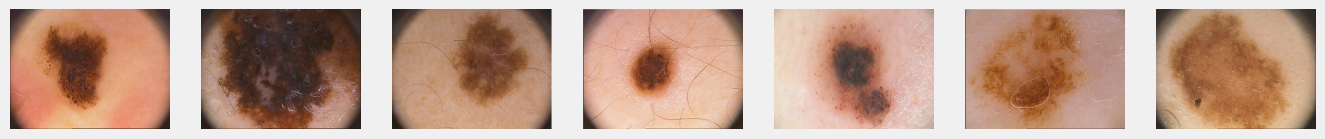

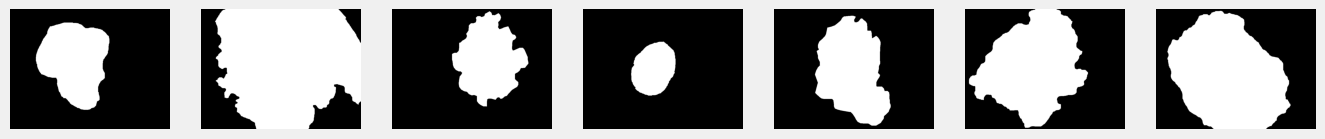

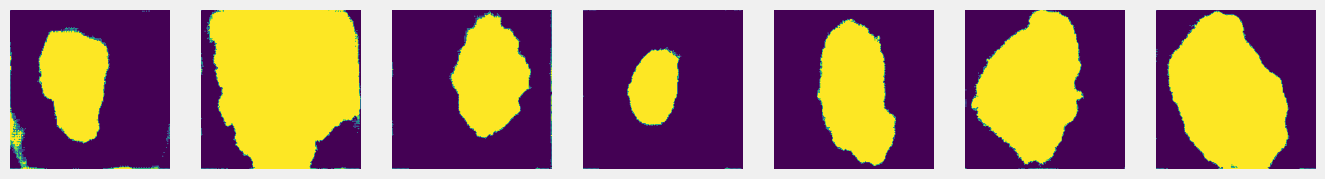

****************************************************************************************************
Train model='UNet' with loss='tversky_loss'


Training model:   0%|          | 0/20 [00:00<?, ?it/s]

Epochs 01/20   train_loss: 0.612  train_iou: 0.353  test_loss: 0.670  test_iou: 0.301
Epochs 02/20   train_loss: 0.521  train_iou: 0.540  test_loss: 0.627  test_iou: 0.558
Epochs 03/20   train_loss: 0.439  train_iou: 0.608  test_loss: 0.478  test_iou: 0.603
Epochs 04/20   train_loss: 0.395  train_iou: 0.636  test_loss: 0.397  test_iou: 0.546
Epochs 05/20   train_loss: 0.344  train_iou: 0.685  test_loss: 0.337  test_iou: 0.695
Epochs 06/20   train_loss: 0.318  train_iou: 0.728  test_loss: 0.294  test_iou: 0.721
Epochs 07/20   train_loss: 0.312  train_iou: 0.719  test_loss: 0.281  test_iou: 0.711
Epochs 08/20   train_loss: 0.270  train_iou: 0.748  test_loss: 0.259  test_iou: 0.810
Epochs 09/20   train_loss: 0.290  train_iou: 0.723  test_loss: 0.277  test_iou: 0.767
Epochs 10/20   train_loss: 0.275  train_iou: 0.751  test_loss: 0.284  test_iou: 0.756
Epochs 11/20   train_loss: 0.279  train_iou: 0.758  test_loss: 0.273  test_iou: 0.802
Epochs 12/20   train_loss: 0.272  train_iou: 0.780  te

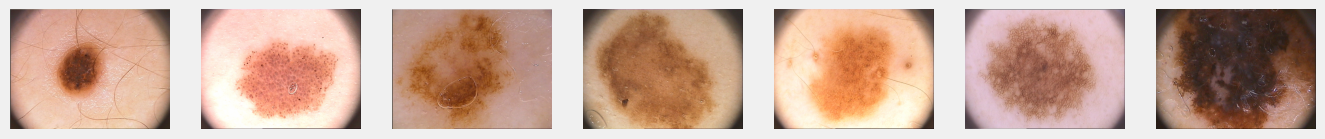

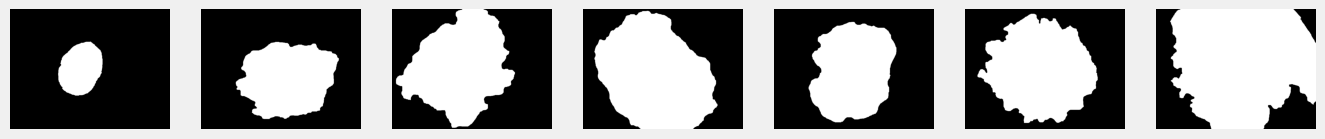

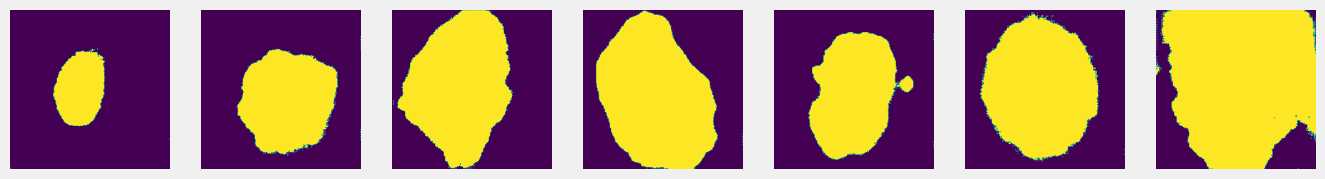

In [25]:
history_unet = super_trainer(UNet)

## score_plot

In [26]:
def score_plot(history, name):
    history_df = pd.DataFrame()
    
    for key, value in history.items():
        df = pd.DataFrame(value)
        df["loss_fn"] = key[:-5]
        df["epoch"] = np.arange(1, df.shape[0]+1)
        history_df = pd.concat([history_df, df])
        
    for score in ("loss", "iou"):
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
        plt.suptitle(f"{name} model {score.upper()}")
        for i, t in enumerate(("train", "test")):
            col = f"{t}_{score}"
            plot = sns.lineplot(data=history_df, 
                                x="epoch", 
                                y=col, 
                                hue="loss_fn", 
                                ax=ax[i],
                                size=2
                               )
            plot.title.set_text(col)
            plot.set_ylabel("")
            epochs = df["epoch"].max()
            plot.set_xticks(range(1, epochs+1))
            if score == "loss": ylim = (0, 0.7)
            if score == "iou": ylim = (0.4, 0.95)
            plot.set_ylim(ylim)

        plt.show()

    #return history_df


## Plot SegNet

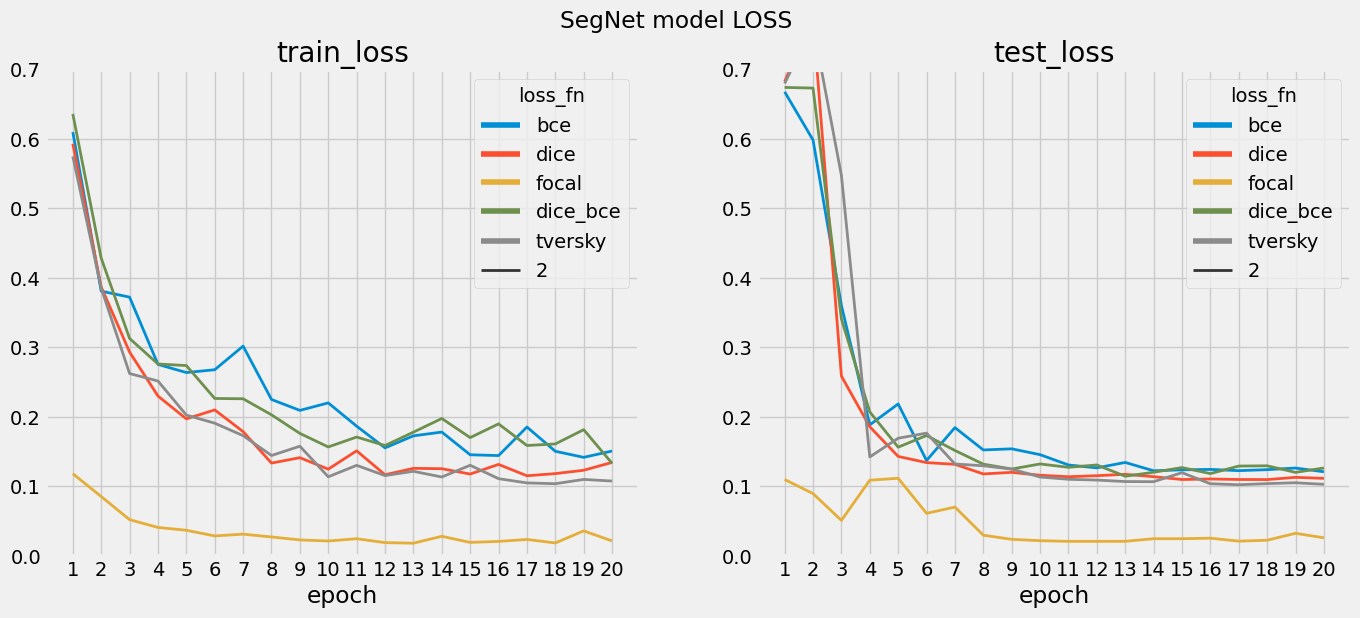

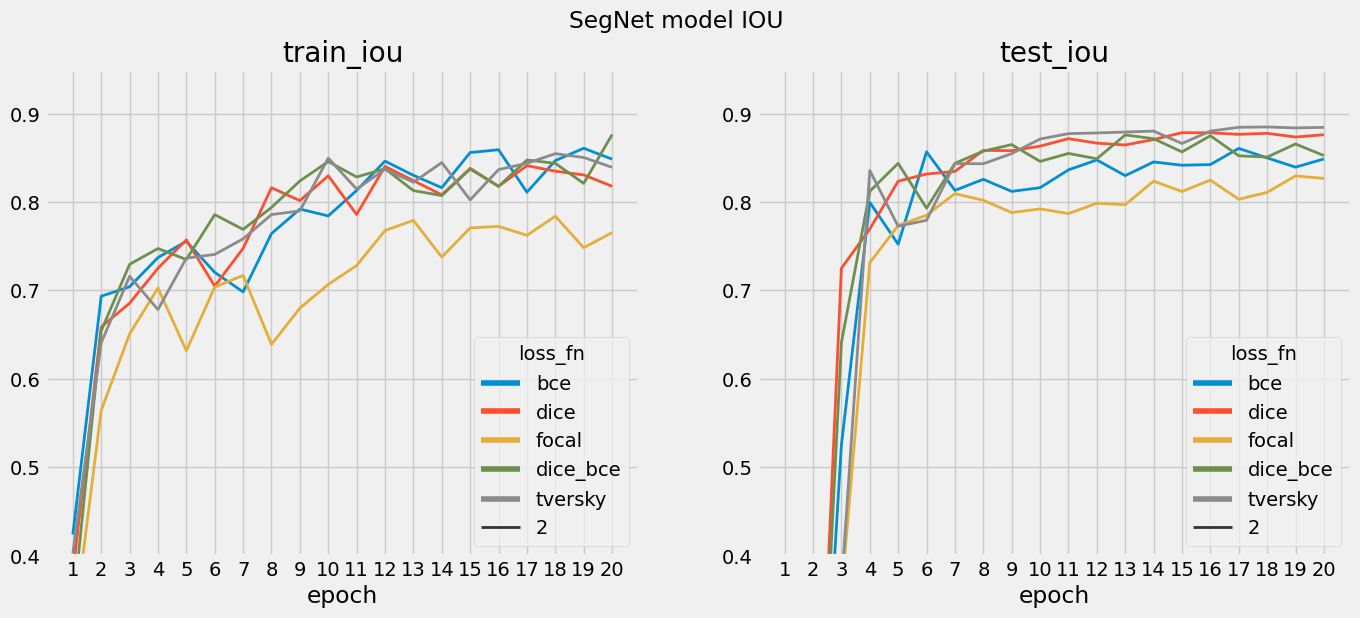

In [27]:
score_plot(history_segnet, name="SegNet")

### Summary Segnet

- На обучении:
    - Все ошибки LOSS находятся в диапазоне `0.1-0.18`, кроме focal_loss - его значение близко к нулю.
    - Метрика IOU для всех функций потерь находится в диапазоне `0.8-0.87`, кроме focal_loss - его значение 0.75-0.77.
- На валидации:
    - Все ошибки LOSS находятся в диапазоне `0.1-0.13`, кроме focal_loss - его значение близко к нулю.
    - Метрика IOU для всех функций потерь находится в диапазоне `0.83-0.88`.
- Хоть `focal_loss` и близок к 0, его  метрика IOU самая `худшая`.
- `Лучше` себя на `валидации` показывают метрики IOU при `dice_loss` и `tversky_loss`.
- Время на обучение 20 эпох: 3 минуты 10 секунд.
- Алгоритм сходится.
- Не смотря на малое количество обучающей выборки переобучения при 20 эпохах не наблюдается.
- Хотя самописный focal_loss и ведет себя, как реализованный в pytorch, и проходит assert, он требует доработки.
- На визуализации инференса отчетливо видно, что все лосс-функции позволяют хорошо сегментировать.
- - При размерах картинки 256*256 и размере батча 16 требует 8GB памяти.

## Plot UNet

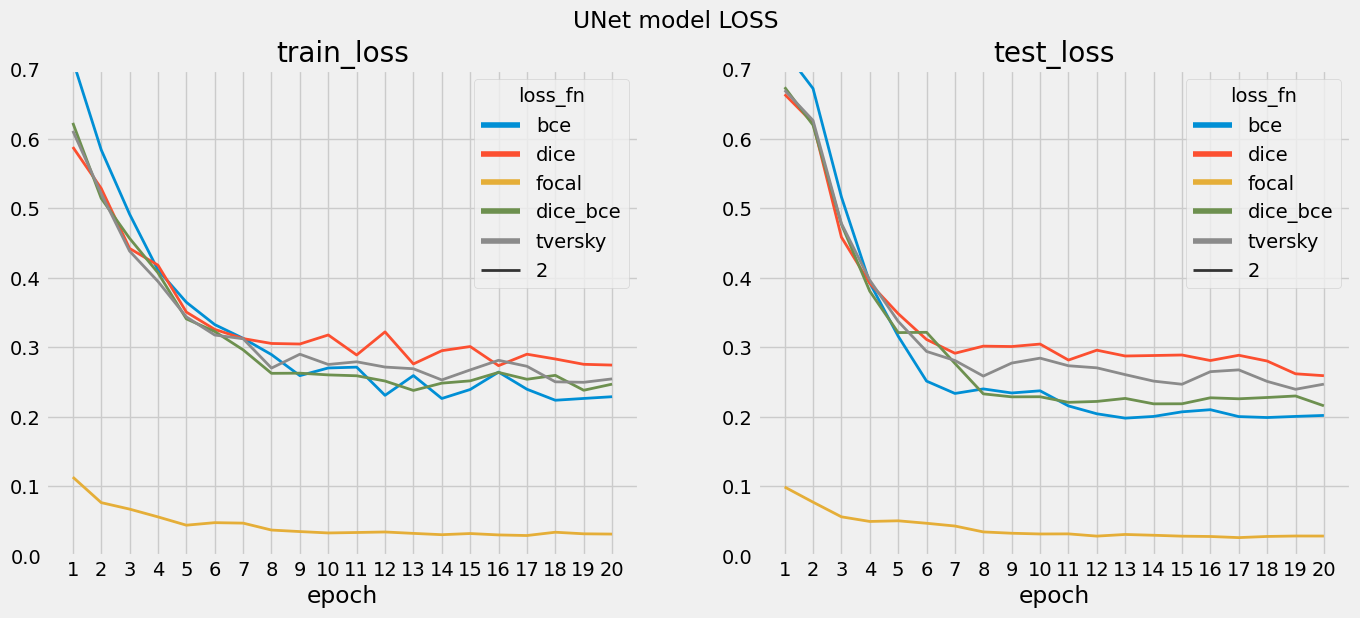

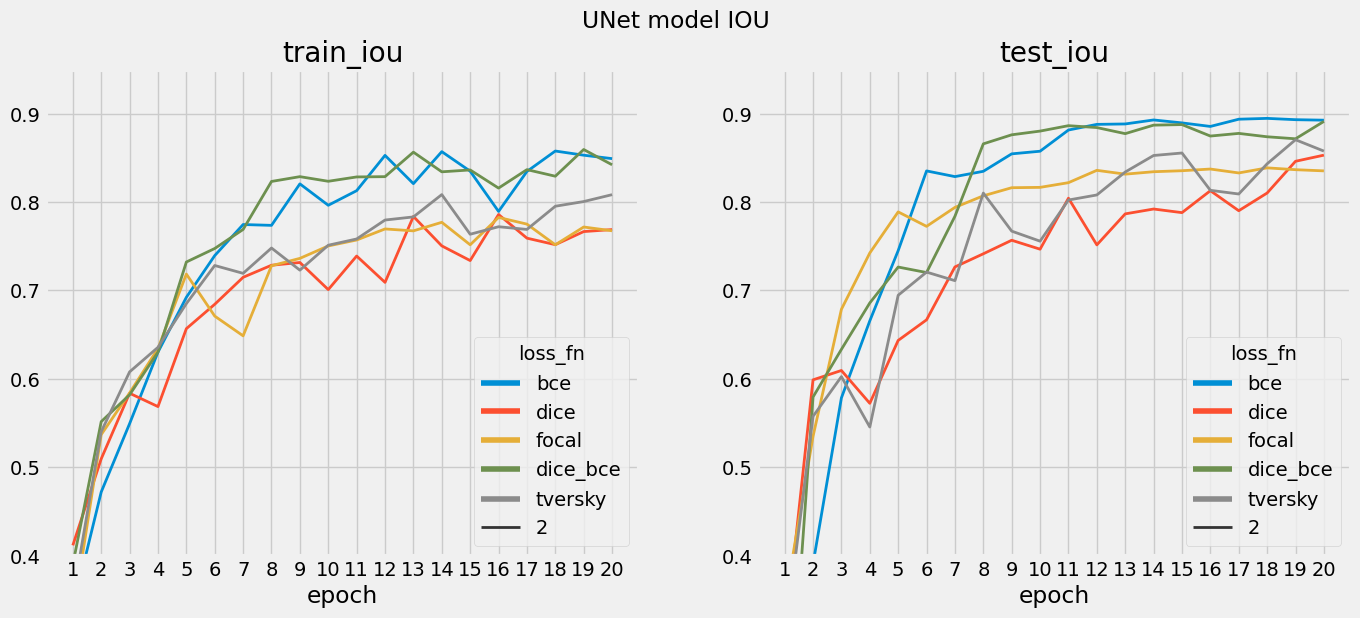

In [28]:
score_plot(history_unet, name="UNet")

### Summary UNet

- На обучении:
    - Все ошибки LOSS находятся в диапазоне `0.22-0.29`, кроме focal_loss - его значение близко к нулю.
    - Метрика IOU для всех функций потерь находится в диапазоне `0.75-0.85`.
- На валидации:
    - Все ошибки LOSS находятся в диапазоне `0.2-0.26`, кроме focal_loss - его значение близко к нулю.
    - Метрика IOU для всех функций потерь находится в диапазоне `0.84-0.9`.
- Хоть `focal_loss` и близок к 0, его  метрика IOU самая `худшая`.
- `Лучше` себя на `валидации` показывают метрики IOU при `bce_loss` и `dice_bce_loss`.
- Время на обучение 20 эпох: 2 минуты 20 секунд.
- Алгоритм сходится.
- Не смотря на малое количество обучающей выборки переобучения при 20 эпохах не наблюдается.
- Хотя самописный focal_loss и ведет себя, как реализованный в pytorch, и проходит assert, он требует доработки.
- На визуализации инференса отчетливо видно, что все лосс-функции позволяют хорошо сегментировать.
- При размерах картинки 256*256 и размере батча 16 требует 4GB памяти.

<a name='summury'></a>

# Summary

[В начало](#hello)  

- Алгоритмы сходится. Не смотря на малое количество обучающей выборки переобучения при 20 эпохах не наблюдается.
- На визуализации инференса отчетливо видно, что все лосс-функции позволяют хорошо сегментировать.
- Хоть `focal_loss` и близок к 0, его  метрика IOU самая `худшая` для обеих сетей. Данный loss требует доработки.
- Для SegNet лучше показали `dice_loss` и `tversky_loss` с IOU близким к 0.88.
- Для UNet лучше показали `bce_loss` и `dice_bce_loss` с IOU близким к 0.9.
- Для Unet  LOSS находятся в диапазоне 0.2-0.26, а для SegNet 0.1 - 0.13.
- Unet быстрее SegNet на 26% при прочих равных.
- Unet требует в два (2) раза меньше памяти при обучении, чем SegNet, при прочих равных.
- `Unet предпочтительнее использовать в бинарной семантической сегментации, чем SegNet, при прочих равных.`